In [1]:
pip install noisereduce


In [2]:
pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 28.5 MB/s eta 0:00:00


In [3]:
!pip install --upgrade librosa

In [4]:
pip install librosa scipy

In [5]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [6]:
pip install pysptk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-1.0.1-cp310-cp310-linux_x86_64.whl size=1241913 sha256=4cea4398a0e6ba22a08ea2504cf03d1f7d0095dc93bccf7225db3e4068bdcd5d
  Stored in directory: /root/.cache/pip/wheels/ba/c2/7f/73c54e1795eeca8f995f95474c8290b78ee0a6306412dc934f
Successfully built pysptk


In [7]:
import pandas as pd
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats

In [9]:
import scipy
from scipy.signal.windows import hamming
import pysptk
from scipy.io import wavfile
from tqdm import tqdm

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Mounted at /content/drive


## Load File

In [12]:
#df = pd.read_csv("IEMOCAP_Updated.csv")
df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP//IEMOCAP_Updated.csv')

In [13]:
df['Audio_Uttrance_Path'] = df['Audio_Uttrance_Path'].str.replace('/content/drive/My Drive', '/content/drive/Shareddrives/CS298')

In [14]:
df.drop(columns=['Arousal', 'Valence', 'Dominance'], inplace=True)

In [16]:
df.drop(columns=[ 'dom', 'val', 'act', 'dimension', 'category', 'Major_Emotion', 'Major'], inplace=True)

In [17]:
df.dropna(subset=['New_Category'], inplace=True)

In [18]:
len(df)

1274

In [ ]:
df['Audio_Uttrance_Path'][0]

## Test the audio Sample

In [ ]:
import librosa
import numpy as np
import scipy
from scipy.signal import lfilter, hamming
import pysptk
from scipy.io import wavfile
import noisereduce as nr

def extract_extended_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Reduce noise using noisereduce
    # y = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2, stationary=False)

    # Features dictionary
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45)
    for i, mfcc in enumerate(mfccs):
        features[f'MFCC_{i}'] = np.mean(mfcc)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])
    pitch_std = np.std(pitches[pitches > 0])
    features['Pitch_mean'] = pitch_mean
    features['Pitch_std'] = pitch_std

    # Energy
    rmse = librosa.feature.rms(y=y)
    features['Energy_mean'] = np.mean(rmse)
    features['Energy_std'] = np.std(rmse)

    # Spectral Centroid
    spec_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['Spectral_Centroid_mean'] = np.mean(spec_centroids)
    features['Spectral_Centroid_std'] = np.std(spec_centroids)

    # Spectral Bandwidth, Rolloff, RMS Energy
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['Spectral_Bandwidth_Mean'] = np.mean(spectral_bandwidth)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['Spectral_Rolloff_Mean'] = np.mean(rolloff)
    rms_energy = librosa.feature.rms(y=y)
    features['RMS_Energy_Mean'] = np.mean(rms_energy)

    # Chroma Features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    for i, chroma in enumerate(chroma_stft):
        features[f'Chroma{i}'] = np.mean(chroma)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['ZCR_mean'] = np.mean(zcr)
    features['ZCR_std'] = np.std(zcr)

    # Loudness (using Energy)
    S, phase = librosa.magphase(librosa.stft(y))
    rms_s = librosa.feature.rms(S=S)
    features['Loudness'] = np.mean(librosa.amplitude_to_db(rms_s, ref=np.max))

    # Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    features['Mel_Spec_Mean'] = np.mean(mel_spec)

    # LPC - Linear Predictive Coefficients
    lpc_coefficients = librosa.lpc(y, order=10)
    for i, coeff in enumerate(lpc_coefficients):
        features[f'LPC_{i}'] = coeff

    return features


In [ ]:
x = extract_extended_features(df['Audio_Uttrance_Path'][0])

## Feature Extraction

In [ ]:
import time
import pandas as pd
from tqdm import tqdm

features_list = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    features = extract_extended_features(row['Audio_Uttrance_Path'])
    features['Emotion'] = row['New_Category']
    features['Speaker_id'] = row['Speaker_id']
    features_list.append(features)


In [ ]:
df = pd.DataFrame(features_list)
df.to_csv("features_labeled.csv", index=False)

In [ ]:
features_df = pd.read_csv("features_labeled.csv")

In [ ]:
features_df.head()

In [ ]:
def extract_emotions(emotion_string):
    emotions = emotion_string.strip("[]").replace("'", "").split(", ")
    return emotions

features_df['Extracted_Emotions'] = features_df['Emotion'].apply(extract_emotions)


In [ ]:
features_df['Extracted_Emotions'] = features_df['Extracted_Emotions'].apply(lambda x: [value.lower() for value in x])

# Function to find most common category value
def most_common_category(row):
    categories = row['Extracted_Emotions']
    counts = {}
    for category in categories:
        counts[category] = counts.get(category, 0) + 1
    return max(counts, key=counts.get)

features_df['main_emotion'] = features_df.apply(most_common_category, axis=1)


In [ ]:
features_df.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,Emotion,Speaker_id,Extracted_Emotions,main_emotion
0,-461.11490,112.019135,-18.254726,30.989008,-8.022955,14.530048,-7.674868,8.910705,-7.732786,9.042817,...,-4.038268,3.407102,-2.520523,1.698326,-0.914442,0.256774,Nervous,Ses04F_script03_1_M000,[nervous],nervous
1,-353.95483,110.984950,-32.917450,44.376503,-28.212845,1.377860,-18.755830,6.655478,-10.875289,8.713849,...,-3.009275,2.519618,-1.901345,1.272239,-0.685757,0.256214,Nervous,Ses04F_script03_1_F000,[nervous],nervous
2,-307.39905,139.353800,-55.655650,35.709640,-24.282602,-8.041896,-15.103067,-7.157278,-6.234850,4.638667,...,-4.198057,3.281164,-2.435601,1.757024,-1.040697,0.348874,Nervous,Ses04F_script03_1_M001,[nervous],nervous
3,-323.83505,105.736390,-38.897120,35.654343,-16.976439,5.943920,-29.648062,-9.719378,-9.015412,-0.471111,...,-3.708133,3.339677,-2.777850,2.047910,-1.184414,0.412443,Nervous,Ses04F_script03_1_F001,[nervous],nervous
4,-381.90390,112.582710,-28.641914,41.377426,-14.992129,13.524291,-15.060657,0.119448,-9.428417,12.295828,...,-3.217988,2.886278,-2.236722,1.461330,-0.787530,0.277015,Nervous,Ses04F_script03_1_M002,[nervous],nervous


## EMotions updation

In [ ]:
unique_values_count = features_df['Emotion'].nunique()
print("Number of unique values in the 'Emotion' column:", unique_values_count)

Number of unique values in the 'Emotion' column: 6


In [ ]:
# Strip and convert to lowercase all values in the 'Emotion' column
features_df['Emotion'] = features_df['Emotion'].str.strip().str.lower()


In [ ]:
features_df['Emotion'][88]

'sad'

In [ ]:
features_df.dropna(subset=['Emotion'], inplace=True)

In [ ]:
len(features_df)

1274

In [ ]:
emotion_counts = features_df['Emotion'].str.strip().str.lower().value_counts()

# Print unique values along with their counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

happy: 297
neutral: 291
angry: 273
sad: 271
nervous: 131
excited: 11


In [ ]:
# Replace "excited" with "happy"
features_df['Emotion'] = features_df['Emotion'].replace('excited', 'happy')
emotion_counts = features_df['Emotion'].str.strip().str.lower().value_counts()
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")


happy: 308
neutral: 291
angry: 273
sad: 271
nervous: 131


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:

X = features_df.iloc[:, :81]
y = features_df['Emotion']

In [ ]:
y

0       nervous
1       nervous
2       nervous
3       nervous
4       nervous
         ...   
1269    neutral
1270    nervous
1271        sad
1272    nervous
1273      happy
Name: Emotion, Length: 1274, dtype: object

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:
y[45]

'happy'

In [ ]:
y_categorical[45]

array([0., 1., 0., 0., 0.], dtype=float32)

## Train-Test SPlit


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in sss.split(X_scaled, y_categorical):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

# Reshape input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Defining the model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)


In [ ]:
history = model.fit(
    X_train_reshaped,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
26/26 [==============================] - 12s 87ms/step - loss: 1.4918 - accuracy: 0.4294 - val_loss: 1.3380 - val_accuracy: 0.5441
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: 1.2560 - accuracy: 0.5264 - val_loss: 1.1856 - val_accuracy: 0.5686
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 1.1295 - accuracy: 0.5681 - val_loss: 1.0881 - val_accuracy: 0.5931
Epoch 4/10
26/26 [==============================] - 0s 16ms/step - loss: 1.0285 - accuracy: 0.6086 - val_loss: 1.0386 - val_accuracy: 0.5931
Epoch 5/10
26/26 [==============================] - 0s 15ms/step - loss: 0.9688 - accuracy: 0.6294 - val_loss: 1.0062 - val_accuracy: 0.6176
Epoch 6/10
26/26 [==============================] - 0s 16ms/step - loss: 0.8779 - accuracy: 0.6540 - val_loss: 0.9796 - val_accuracy: 0.6422
Epoch 7/10
26/26 [==============================] - 0s 14ms/step - loss: 0.8152 - accuracy: 0.6834 - val_loss: 0.9761 - val_accuracy: 0.6225
Epoch 8/10
2

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Test accuracy: {accuracy*100:.2f}%')

Test accuracy: 60.78%


In [ ]:
from sklearn.metrics import f1_score
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

#  F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

8/8 [==============================] - 0s 4ms/step
F1 Score: 0.6069


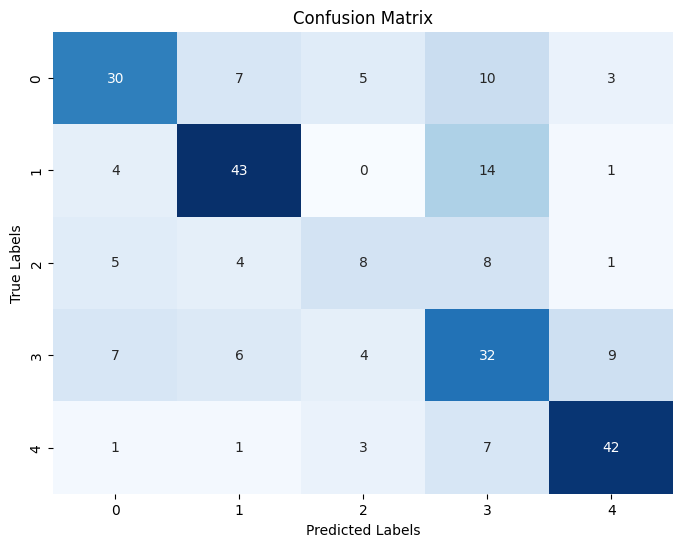

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Attention
from tensorflow.keras.models import Model

def build_model(hp):
    inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    x = Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))(inputs)
    x = Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05))(x)
    # Attention layer
    query_value_attention_seq = Attention()([x, x])
    x = LSTM(64)(query_value_attention_seq)
    outputs = Dense(y_categorical.shape[1], activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_bilstm'
)

tuner.search(X_train_reshaped, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])


Trial 5 Complete [00h 00m 35s]
val_accuracy: 0.6715686321258545

Best val_accuracy So Far: 0.6715686321258545
Total elapsed time: 00h 03m 07s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
384               |352               |units
0.25              |0.15              |dropout



FatalValueError: All callbacks used during a search should be deep-copyable (since they are reused across trials). It is not possible to do `copy.deepcopy([<keras.src.callbacks.EarlyStopping object at 0x7fcc71c34580>])`

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


In [ ]:
def transformer_encoder(inputs):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward neural network
    ffnn = Dense(units=inputs.shape[-1], activation='relu')(x)
    ffnn_output = Dense(units=inputs.shape[-1])(ffnn)
    x = Dropout(0.1)(ffnn_output)
    encoder_output = LayerNormalization(epsilon=1e-6)(x + ffnn_output)
    return encoder_output

In [ ]:
input_shape = X_train_reshaped.shape[1:]  # Example: (sequence_length, feature_dim)
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs)
x = GlobalAveragePooling1D()(x)
outputs = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the Transformer model
history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=34,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

In [ ]:
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f'Transformer Model Accuracy: {accuracy:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Transformer Model F1 Score: {f1:.4f}')

In [ ]:
x

#openSmile


In [ ]:
!pip install pyopensmile

ERROR: Could not find a version that satisfies the requirement pyopensmile (from versions: none)
ERROR: No matching distribution found for pyopensmile


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# optimizer = Adam(learning_rate=0.0001)
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model 3


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

##LSTM


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Defining the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Training the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)


## MelSpectogram

In [ ]:
import pandas as pd
import librosa
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

def extract_melspectrogram(audio_path, sr=22050, n_mels=128, figsize=(128, 128)):
  """Extracts melspectrogram from an audio file.

  Args:
      audio_path: Path to the audio file.
      sr: Sampling rate (default: 22050).
      n_mels: Number of mel filters (default: 128).
      figsize: Desired output image size (default: (128, 128)).

  Returns:
      A NumPy array representing the melspectrogram image.
  """
  y, _ = librosa.load(audio_path, sr=sr)
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
  # Normalize mel spectrogram to [0, 1] range
  mel_spectrogram = librosa.power_to_db(mel_spectrogram).astype("float32") / 80
  return librosa.feature.inverse.mel_to_image(mel_spectrogram, figsize=figsize)

def create_melspectrogram_dataset(df, audio_path_col="Audio_Uttrance_Path", target_col="New_Category", image_size=(128, 128)):
  """Creates a dataset of mel spectrograms and labels from a DataFrame.

  Args:
      df: Pandas DataFrame containing audio data.
      audio_path_col: Column name containing audio file paths (default: "Audio_Uttrance_Path").
      target_col: Column name containing class labels (default: "New_Category").
      image_size: Desired image size (default: (128, 128)).

  Returns:
      A tuple containing training and validation data generators.
  """
  X = []
  y = []
  for index, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    audio_path = row[audio_path_col]
    mel_spectrogram = extract_melspectrogram(audio_path, figsize=image_size)
    X.append(mel_spectrogram)
    y.append(row[target_col])

  X = np.array(X)
  y = np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
  val_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
  val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

  return train_generator, val_generator

def build_model(input_shape):
  """Builds a CNN model for audio classification using mel spectrograms.

  Args:
      input_shape: Shape of the input image (e.g., (128, 128, 1)).

  Returns:
      A compiled Keras model.
  """
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dense(len(class_labels), activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])

  return model


In [ ]:
# Define paths and hyperparameters
audio_path_col = "Audio_Uttrance_Path"
target_col = "New_Category"
image_size = (128, 128)
epochs = 50  # Adjust this as needed

# Create mel spectrogram dataset
train_generator, val_generator = create_melspectrogram_dataset(df, audio_path_col, target_col, image_size)

# Get the number of unique emotion categories
num_classes = len(set(df[target_col]))

# Build the CNN model
input_shape = train_generator.image_shape
model = build_model(input_shape)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

# Train the model
model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping])

# Evaluate the model on the test set (replace with actual test data if available)
test_generator = create_melspectrogram_dataset(df.iloc[int(0.8*len(df)):], audio_path_col, target_col, image_size)  # Assuming 80% for training, 20% for testing
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_melspectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(5, 3))
    img = librosa.display.specshow(mel_spec_db, ax=ax, x_axis='time', y_axis='mel')
    fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# Loop through audio files and extract mel-spectrograms
for i, audio_path in enumerate(df['Audio_Uttrance_Path']):
    save_path = f'melspecs/melspec_{i}.png'
    extract_melspectrogram(audio_path, save_path)